In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sklearn.datasets

import numpy as np
import tensorflow as tf

import official.nlp.modeling.layers as nlp_layers

In [2]:
plt.rcParams['figure.dpi'] = 140

DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(vmin=0, vmax=1,)
DEFAULT_N_GRID = 100

def make_training_data(sample_size=500):
  """Create two moon training dataset."""
  train_examples, train_labels = sklearn.datasets.make_moons(
      n_samples=2 * sample_size, noise=0.1)

  # Adjust data position slightly.
  train_examples[train_labels == 0] += [-0.1, 0.2]
  train_examples[train_labels == 1] += [0.1, -0.2]

  return train_examples, train_labels

def make_testing_data(x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID):
  """Create a mesh grid in 2D space."""
  # testing data (mesh grid over data space)
  x = np.linspace(x_range[0], x_range[1], n_grid)
  y = np.linspace(y_range[0], y_range[1], n_grid)
  xv, yv = np.meshgrid(x, y)
  return np.stack([xv.flatten(), yv.flatten()], axis=-1)

def make_ood_data(sample_size=500, means=(2.5, -1.75), vars=(0.01, 0.01)):
  return np.random.multivariate_normal(
      means, cov=np.diag(vars), size=sample_size)

In [3]:
def plot_uncertainty_surface(test_uncertainty, ax, cmap=None):
  """Visualizes the 2D uncertainty surface.

  For simplicity, assume these objects already exist in the memory:

    test_examples: Array of test examples, shape (num_test, 2).
    train_labels: Array of train labels, shape (num_train, ).
    train_examples: Array of train examples, shape (num_train, 2).

  Arguments:
    test_uncertainty: Array of uncertainty scores, shape (num_test,).
    ax: A matplotlib Axes object that specifies a matplotlib figure.
    cmap: A matplotlib colormap object specifying the palette of the
      predictive surface.

  Returns:
    pcm: A matplotlib PathCollection object that contains the palette
      information of the uncertainty plot.
  """
  # Normalize uncertainty for better visualization.
  test_uncertainty = test_uncertainty / np.max(test_uncertainty)

  # Set view limits.
  ax.set_ylim(DEFAULT_Y_RANGE)
  ax.set_xlim(DEFAULT_X_RANGE)

  # Plot normalized uncertainty surface.
  pcm = ax.imshow(
      np.reshape(test_uncertainty, [DEFAULT_N_GRID, DEFAULT_N_GRID]),
      cmap=cmap,
      origin="lower",
      extent=DEFAULT_X_RANGE + DEFAULT_Y_RANGE,
      vmin=DEFAULT_NORM.vmin,
      vmax=DEFAULT_NORM.vmax,
      interpolation='bicubic',
      aspect='auto')

  # Plot training data.
  ax.scatter(train_examples[:, 0], train_examples[:, 1],
             c=train_labels, cmap=DEFAULT_CMAP, alpha=0.5)
  ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

  return pcm

In [4]:
def plot_predictions(pred_probs, model_name=""):
  """Plot normalized class probabilities and predictive uncertainties."""
  # Compute predictive uncertainty.
  uncertainty = pred_probs * (1. - pred_probs)

  # Initialize the plot axes.
  fig, axs = plt.subplots(1, 2, figsize=(14, 5))

  # Plots the class probability.
  pcm_0 = plot_uncertainty_surface(pred_probs, ax=axs[0])
  # Plots the predictive uncertainty.
  pcm_1 = plot_uncertainty_surface(uncertainty, ax=axs[1])

  # Adds color bars and titles.
  fig.colorbar(pcm_0, ax=axs[0])
  fig.colorbar(pcm_1, ax=axs[1])

  axs[0].set_title(f"Class Probability, {model_name}")
  axs[1].set_title(f"(Normalized) Predictive Uncertainty, {model_name}")

  plt.show()

In [5]:
# Load the train, test and OOD datasets.
train_examples, train_labels = make_training_data(
    sample_size=500)
test_examples = make_testing_data()
ood_examples = make_ood_data(sample_size=500)

# Visualize
pos_examples = train_examples[train_labels == 0]
neg_examples = train_examples[train_labels == 1]

In [6]:
class DeepResNet(tf.keras.Model):
  """Defines a multi-layer residual network."""
  def __init__(self, num_classes, num_layers=3, num_hidden=128,
               dropout_rate=0.1, **classifier_kwargs):
    super().__init__()
    # Defines class meta data.
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.dropout_rate = dropout_rate
    self.classifier_kwargs = classifier_kwargs

    # Defines the hidden layers.
    self.input_layer = tf.keras.layers.Dense(self.num_hidden, trainable=False)
    self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]

    # Defines the output layer.
    self.classifier = self.make_output_layer(num_classes)

  def call(self, inputs):
    # Projects the 2d input data to high dimension.
    hidden = self.input_layer(inputs)

    # Computes the ResNet hidden representations.
    for i in range(self.num_layers):
      resid = self.dense_layers[i](hidden)
      resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
      hidden += resid

    return self.classifier(hidden)

  def make_dense_layer(self):
    """Uses the Dense layer as the hidden layer."""
    return tf.keras.layers.Dense(self.num_hidden, activation="relu")

  def make_output_layer(self, num_classes):
    """Uses the Dense layer as the output layer."""
    return tf.keras.layers.Dense(
        num_classes, **self.classifier_kwargs)

In [7]:
dense = tf.keras.layers.Dense(units=10)
dense = nlp_layers.SpectralNormalization(dense, norm_multiplier=0.9)
batch_size = 32
input_dim = 1024
num_classes = 10
gp_layer = nlp_layers.RandomFeatureGaussianProcess(units=num_classes,
                                                  num_inducing=1024,
                                                  normalize_input=False,
                                                  scale_random_features=True,
                                                  gp_cov_momentum=-1)

embedding = tf.random.normal(shape=(batch_size, input_dim))

logits, covmat = gp_layer(embedding)

In [10]:
nlp_layers.SpectralNormalization(dense, norm_multiplier=0.9)

In [13]:
class DeepResNetSNGP(DeepResNet):
  def __init__(self, spec_norm_bound=0.9, **kwargs):
    self.spec_norm_bound = spec_norm_bound
    super().__init__(**kwargs)

  def make_dense_layer(self):
    """Applies spectral normalization to the hidden layer."""
    dense_layer = super().make_dense_layer()
    return nlp_layers.SpectralNormalization(
        dense_layer, norm_multiplier=self.spec_norm_bound)

  def make_output_layer(self, num_classes):
    """Uses Gaussian process as the output layer."""
    return nlp_layers.RandomFeatureGaussianProcess(
        num_classes,
        gp_cov_momentum=-1,
        **self.classifier_kwargs)

  def call(self, inputs, training=False, return_covmat=False):
    # Gets logits and a covariance matrix from the GP layer.
    logits, covmat = super().call(inputs)

    # Returns only logits during training.
    if not training and return_covmat:
      return logits, covmat

    return logits

In [18]:
resnet_config = dict(num_classes=2, num_layers=6, num_hidden=128)
sngp_model = DeepResNetSNGP(**resnet_config)
sngp_model.build((None, 2))

In [19]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):

  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the beginning of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()
      
class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs["callbacks"] = list(kwargs.get("callbacks", []))
    kwargs["callbacks"].append(ResetCovarianceCallback())

    return super().fit(*args, **kwargs)

In [20]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy(),
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)
train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)
fit_config = dict(batch_size=128, epochs=100)

In [21]:
sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)
sngp_model.compile(**train_config)
sngp_model.fit(train_examples, train_labels, **fit_config)

Epoch 1/100
8/8 [==============================] - 1s 4ms/step - loss: 0.6671 - sparse_categorical_accuracy: 0.7770
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 0.6180 - sparse_categorical_accuracy: 0.9870
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 0.5827 - sparse_categorical_accuracy: 0.9970
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 0.5565 - sparse_categorical_accuracy: 0.9990
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 0.5360 - sparse_categorical_accuracy: 0.9990
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 0.5165 - sparse_categorical_accuracy: 0.9990
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 0.5007 - sparse_categorical_accuracy: 0.9990
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 0.4861 - sparse_categorical_accuracy: 0.9990
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 0

In [65]:
sngp_logits, sngp_covmat = sngp_model(test_examples, return_covmat=True)
sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]
sngp_logits_adjusted = sngp_logits / tf.sqrt(1. + (np.pi / 8.) * sngp_variance)
sngp_probs = tf.nn.softmax(sngp_logits_adjusted, axis=-1)[:, 0]

In [108]:
covmat

<tf.Tensor: shape=(32, 32), dtype=float32, numpy=
array([[ 1.0170573 ,  0.00876945,  0.05379316, ...,  0.00342394,
        -0.04501778, -0.00741336],
       [ 0.00876945,  0.97350967, -0.02999917, ..., -0.00205139,
         0.02900597, -0.06633066],
       [ 0.05379316, -0.02999917,  1.0238861 , ..., -0.01762899,
        -0.00376113,  0.01305594],
       ...,
       [ 0.00342394, -0.00205139, -0.01762899, ...,  0.97740316,
         0.02199926, -0.02936801],
       [-0.04501778,  0.02900596, -0.00376113, ...,  0.02199926,
         0.9744167 ,  0.04071349],
       [-0.00741335, -0.06633066,  0.01305593, ..., -0.02936801,
         0.04071349,  0.97177124]], dtype=float32)>

In [68]:
def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
  # Computes uncertainty-adjusted logits using the built-in method.
  logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
      logits, covmat, mean_field_factor=lambda_param)

  return tf.nn.softmax(logits_adjusted, axis=-1)[:, 0]

In [104]:
sngp_logits, sngp_covmat = sngp_model(test_examples, return_covmat=True)
sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)
sngp_probs

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([0.54548264, 0.55129266, 0.5534109 , ..., 0.5337437 , 0.5300747 ,
       0.5254216 ], dtype=float32)>

In [81]:
resnet_model = DeepResNet(**resnet_config)
resnet_model.build((None, 2))
resnet_model.summary()

Model: "deep_res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            multiple                  384       
                                                                 
 dense_30 (Dense)            multiple                  16512     
                                                                 
 dense_31 (Dense)            multiple                  16512     
                                                                 
 dense_32 (Dense)            multiple                  16512     
                                                                 
 dense_33 (Dense)            multiple                  16512     
                                                                 
 dense_34 (Dense)            multiple                  16512     
                                                                 
 dense_35 (Dense)            multiple                 

In [89]:
def mc_dropout_sampling(test_examples):
  # Enable dropout during inference.
  return resnet_model(test_examples, training=True)

# Monte Carlo dropout inference.
num_ensemble = 10
dropout_logit_samples = [mc_dropout_sampling(test_examples) for _ in range(num_ensemble)]
dropout_prob_samples = [tf.nn.softmax(dropout_logits, axis=-1)[:, 0] for dropout_logits in dropout_logit_samples]
dropout_probs = tf.reduce_mean(dropout_prob_samples, axis=0)
dropout_probs

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([0.9828253 , 0.98979795, 0.99242175, ..., 0.929783  , 0.89462596,
       0.83501303], dtype=float32)>

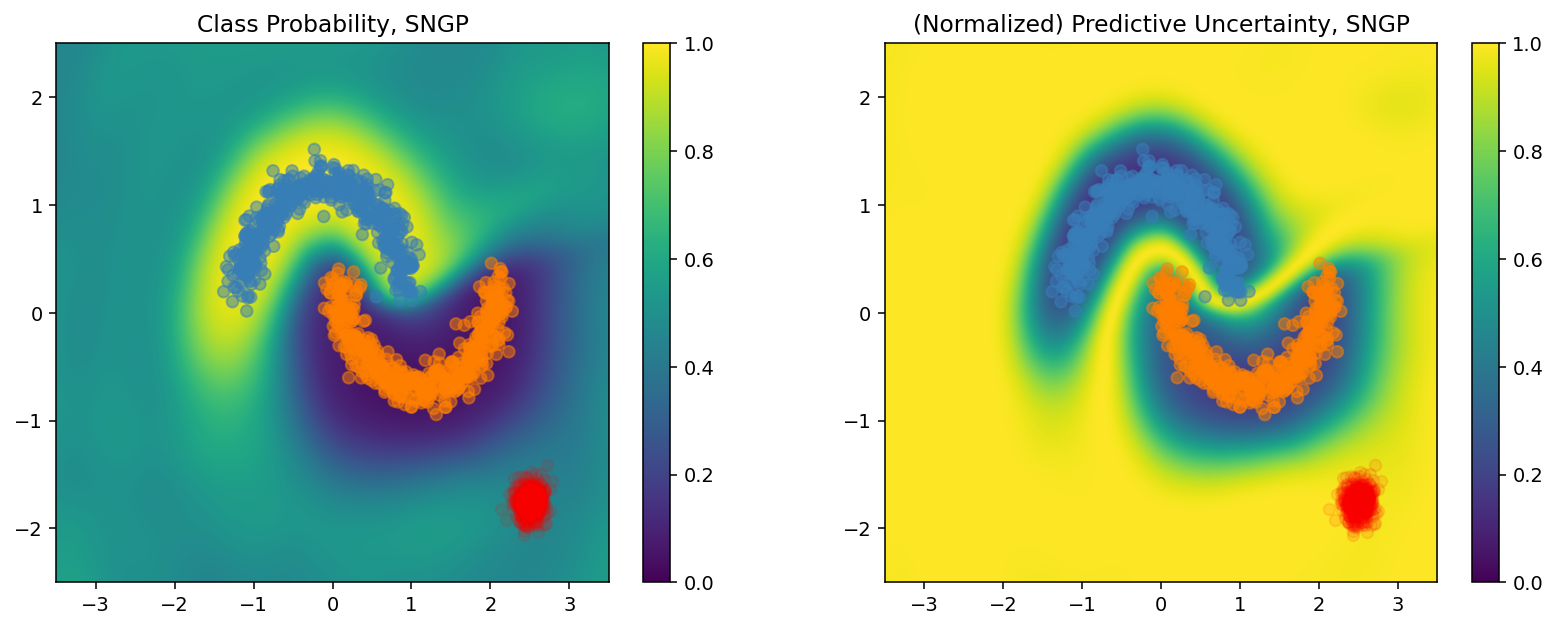

In [93]:
plot_predictions(sngp_probs, model_name="SNGP")

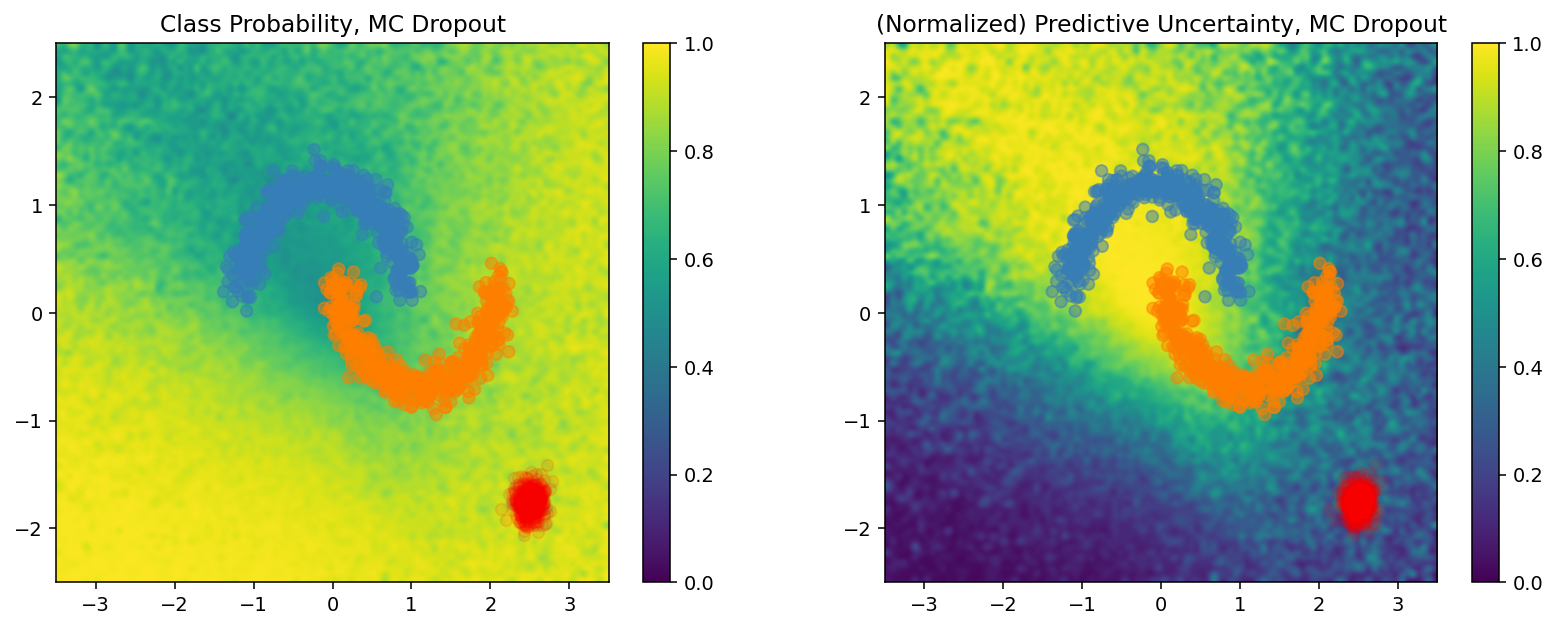

In [97]:
plot_predictions(dropout_probs, model_name="MC Dropout")